# Regressão Logística Multinomial

Para esta atividade usaremos um conjunto de dados sobre métricas do coração de pacientes, com o objetivo de determinar se o paciente é normal, suspeito ou com doença patológica. O conjunto de dado pode ser encontrado no [GitHub](https://raw.githubusercontent.com/bkrai/R-files-from-YouTube/main/Cardiotocographic.csv) de alguns usuários.

Abaixo encontra-se o dicionário de dados:

* LB: baseline value (SisPorto)
* AC: accelerations (SisPorto)
* FM: foetal movement (SisPorto)
* UC: uterine contractions (SisPorto)
* DL: light decelerations
* DS: severe decelerations
* DP: prolongued decelerations
* ASTV: percentage of time with abnormal short term variability (SisPorto)
* mSTV: mean value of short term variability (SisPorto)
* ALTV: percentage of time with abnormal long term variability (SisPorto)
* mLTV: mean value of long term variability (SisPorto)
* Width: histogram width
* Min: low freq. of the histogram
* Max: high freq. of the histogram
* Nmax: number of histogram peaks
* Nzeros: number of histogram zeros
* Mode: histogram mode
* Mean: histogram mean
* Median: histogram median
* Variance: histogram variance
* Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
* NSP: Normal=0; Suspect=1; Pathologic=2


O objetivo é entender/prever a variável `NSP` em função das demais.

Obs: Não se preocupe se não entender o significado de cada variável, estamos lidando com um problema técnico e provavelmente você não terá um especialista na área e nem tempo suficiente para entender sobre a área de negócio para este exercício. Foque na construção do modelo de regressão logística.

In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.metrics import confusion_matrix

# criando mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

## Atividade 1: Importe o conjunto de dados, verifique se há dados faltantes e a correlação entre as variáveis.

In [4]:
df = pd.read_excel('cardio.xlsx')
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000000,0.0,0.000000,0.000000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,0


In [5]:
# seu código
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LB,2126.0,133.303857,9.840844,106.0,126.000000,133.000000,140.000000,160.000000
AC,2126.0,0.003170,0.003860,0.0,0.000000,0.001630,0.005631,0.019284
FM,2126.0,0.009474,0.046670,0.0,0.000000,0.000000,0.002512,0.480634
UC,2126.0,0.004357,0.002940,0.0,0.001876,0.004482,0.006525,0.014925
DL,2126.0,0.001885,0.002962,0.0,0.000000,0.000000,0.003264,0.015385
DS,2126.0,0.000004,0.000063,0.0,0.000000,0.000000,0.000000,0.001353
DP,2126.0,0.000157,0.000580,0.0,0.000000,0.000000,0.000000,0.005348
ASTV,2126.0,46.990122,17.192814,12.0,32.000000,49.000000,61.000000,87.000000
MSTV,2126.0,1.332785,0.883241,0.2,0.700000,1.200000,1.700000,7.000000
ALTV,2126.0,9.846660,18.396880,0.0,0.000000,0.000000,11.000000,91.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

## Atividade 2: Verifique se a variável está balanceada.

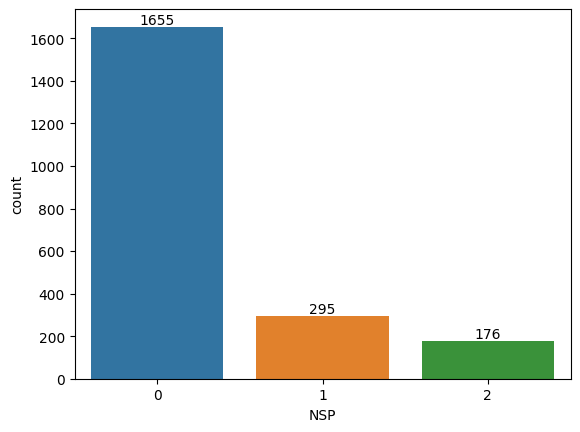

In [8]:
# seu código
ax = sns.countplot(x=df.NSP);
ax.bar_label(ax.containers[0])
plt.show() 

## Atividade 3: Use as variáveis que achar relevante e separe as variáveis em $X$ e $y$, a seguir crie um modelo de regressão logística.

In [13]:
correlacao_NSP = df.corr()['NSP'].to_frame().reset_index()

In [21]:
colunas_selecionadas = list(correlacao_NSP[abs(correlacao_NSP.NSP)>0.15]['index'])

In [55]:
colunas_selecionadas.append('Tendency')
colunas_selecionadas

['AC',
 'UC',
 'DP',
 'ASTV',
 'ALTV',
 'MLTV',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'NSP',
 'Tendency']

In [56]:
df_new = df[colunas_selecionadas]

In [57]:
X = df_new.drop(columns='NSP')
y = df_new['NSP']

In [58]:
smote_model = SMOTE(random_state=42)

In [59]:
# seu código
X_res, y_res = smote_model.fit_resample(X, y)

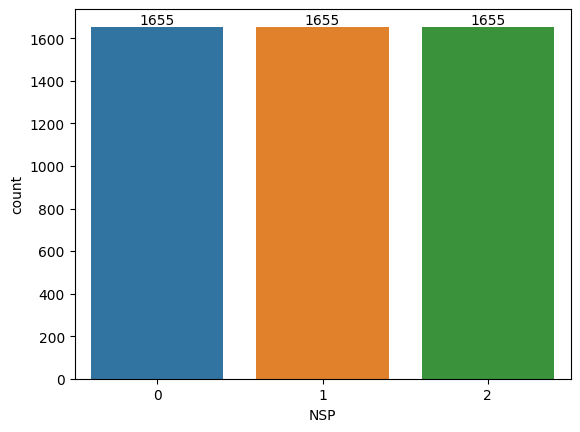

In [60]:
# seu código
ax = sns.countplot(x=y_res);
ax.bar_label(ax.containers[0])
plt.show() 

In [61]:
X = sm.add_constant(X_res,has_constant='add')

In [62]:
modelo_regressao_logistica = MNLogit(y_res, X).fit()

Optimization terminated successfully.
         Current function value: 0.367722
         Iterations 14


## Atividade 4: Faça previsões e avalie o modelo.

In [63]:
modelo_regressao_logistica.predict(X)


,0,1,2
0,7.030609e-05,0.052859,9.470710e-01
1,9.998723e-01,0.000128,1.363699e-09
2,9.988890e-01,0.001111,4.588574e-08
3,9.985791e-01,0.001421,7.230418e-08
4,9.999551e-01,0.000045,2.865825e-10
...,...,...,...
4960,1.847608e-03,0.291952,7.062000e-01
4961,2.211840e-08,0.001658,9.983415e-01
4962,4.540440e-02,0.262491,6.921046e-01
4963,1.846869e-01,0.343623,4.716898e-01


In [64]:
y_pred = modelo_regressao_logistica.predict(X).idxmax(axis=1)


In [65]:
print(modelo_regressao_logistica.summary())

                          MNLogit Regression Results                          
Dep. Variable:                    NSP   No. Observations:                 4965
Model:                        MNLogit   Df Residuals:                     4941
Method:                           MLE   Df Model:                           22
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.6653
Time:                        19:56:47   Log-Likelihood:                -1825.7
converged:                       True   LL-Null:                       -5454.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
     NSP=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.4896      1.044    -18.669      0.000     -21.536     -17.443
AC          -891.3443     55.485    -16.064      0.000   -1000.094    -782.595
UC          -232.7595     25.749     -9.040      0.0

In [66]:
matriz_confusao = confusion_matrix(y_res, y_pred)
matriz_confusao

array([[1431,  181,   43],
       [  86, 1366,  203],
       [  27,  208, 1420]], dtype=int64)

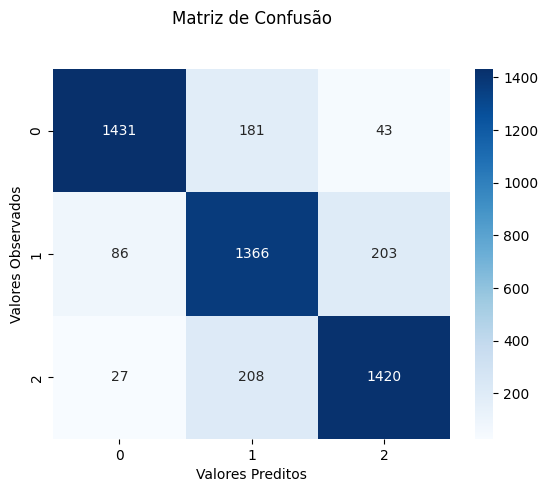

In [67]:
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

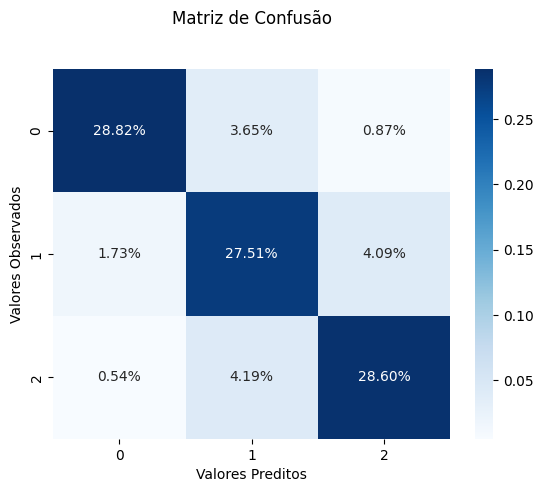

In [68]:
sns.heatmap(matriz_confusao/np.sum(matriz_confusao),
            annot=True, fmt='.2%', cmap='Blues')
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

In [69]:
print(classification_report(y_res, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1655
           1       0.78      0.83      0.80      1655
           2       0.85      0.86      0.86      1655

    accuracy                           0.85      4965
   macro avg       0.85      0.85      0.85      4965
weighted avg       0.85      0.85      0.85      4965



In [77]:
depara = {
    0:'Normal',
    1:'Suspect',
    2:'Pathologic',
}

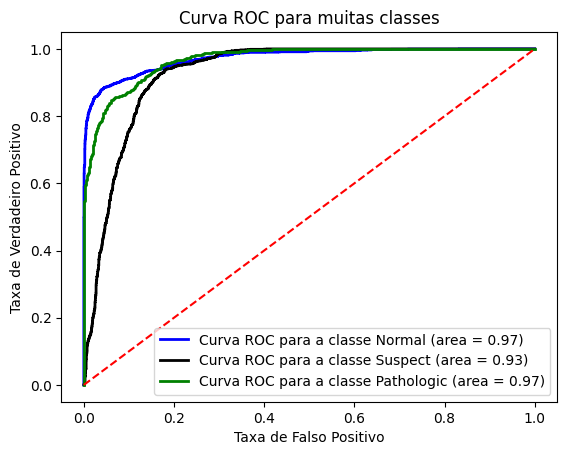

In [78]:
y_cat = label_binarize(y_res, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
colors = ['blue','black','green']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], modelo_regressao_logistica.predict(X).iloc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Curva ROC para a classe {depara[i]} (area = {round(roc_auc[i], 2)})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC para muitas classes')
plt.legend(loc="lower right");

## Atividade 5: Faça a previsão para um paciente que apresenta as seguintes características:

* `LB` = 121
* `AC` = 0.004176
* `FM` = 0.0
* `UC` = 0.007541
* `DL` = 0.003176
* `DS` = 0.0
* `DP` = 0.0
* `ASTV` = 20
* `mSTV` = 2.3
* `ALTV` = 0
* `mLTV` = 11.5
* `Width` = 129
* `Min` = 54
* `Max` = 171
* `Nmax` = 5
* `Nzeros` = 0
* `Mode` = 140
* `Mean` = 136
* `Median` = 123
* `Variance` = 14
* `Tendency` = 1

In [80]:
colunas_new = df.columns[:-1]

In [79]:
valor_new = [121,0.004176,0.0,0.007541,0.003176\
    ,0.0,0.0,20,2.3,0,11.5,129,54,171, 5,0,140,136\
    ,123,14,1]

In [87]:
data_new =dict(zip(colunas_new,valor_new))

In [93]:
colunas_selecionadas_sem_target = colunas_selecionadas
colunas_selecionadas_sem_target.remove('NSP')

In [109]:
# seu código
df_prev = pd.DataFrame(data = data_new,index=[0])
df_prev2 = df_prev[colunas_selecionadas_sem_target]


In [110]:
X = sm.add_constant(df_prev2, has_constant='add')

In [111]:
y_pred = (modelo_regressao_logistica.predict(X)).idxmax(axis=1)
print(f'De acordo com os dados de coração de pacientes, o modelo previu que o paciente está {depara[y_pred.values[0]]}')

De acordo com os dados de coração de pacientes, o modelo previu que o paciente está Normal
